# 1. Install Dependencies and Setup

In [2]:
%pip install tensorflow tensorflow-gpu opencv-python matplotlib --user

Note: you may need to restart the kernel to use updated packages.


In [2]:
#%pip install tensorflow-hub==0.8.0
%conda uninstall tflite-model-maker


Note: you may need to restart the kernel to use updated packages.


'conda' is not recognized as an internal or external command,
operable program or batch file.


In [5]:
#%pip install --user -r official/requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'official/requirements.txt'


In [5]:
#%pip install tflite-model-maker object-detection jupyter-server --user

  Using cached scipy-1.8.1-cp39-cp39-win_amd64.whl (36.9 MB)


In [3]:
%pip install protobuf

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

TypeError: Value already registered for Mapping

In [7]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

NameError: name 'tf' is not defined

# 2. Load Data

### 2.1 Load Images

In [2]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [3]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

NameError: name 'tf' is not defined

In [4]:
iterator = train_images.as_numpy_iterator()
#iterator.next()


NameError: name 'train_images' is not defined

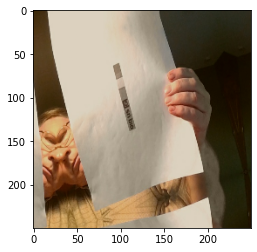

In [8]:
plt.imshow(iterator.next())

In [9]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [10]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

### 2.2 Prepare Labels

In [11]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        #print(type(label['keypoints']))
        w = label['image_width']
        h = label['image_height']
        norm_keypoints = np.squeeze([label['keypoints'][0]/ w, label['keypoints'][1]/h,
                          label['keypoints'][2]/ w, label['keypoints'][3]/h,
                          label['keypoints'][4]/ w, label['keypoints'][5]/h,
                          label['keypoints'][6]/ w, label['keypoints'][7]/h,
                          label['keypoints'][8]/ w, label['keypoints'][9]/h,
                          label['keypoints'][10]/ w, label['keypoints'][11]/h
                         ])
                          
    return norm_keypoints
#lp = os.path.join('aug_data', 'train','labels', '15c5ad1f-e74e-11ec-a668-94e23cbfc22c.0.json')
#print(lp)
#load_labels(lp)

In [12]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [13]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [14]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [15]:
val_labels.as_numpy_iterator().next()

(array([0.4233 , 0.12427, 0.4597 , 0.12054, 0.429  , 0.2654 , 0.466  ,
        0.2617 , 0.439  , 0.3855 , 0.4685 , 0.3826 ], dtype=float16),)

### 2.3. Combine Labels and Images

In [16]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [17]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [18]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

### 2.4 View Samples

In [19]:
data_samples = train.as_numpy_iterator()

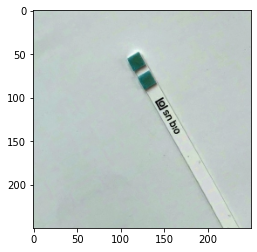

In [20]:
res = data_samples.next()
plt.imshow(res[0][0])

[ 45.12  96.75  63.47  80.3   84.3  141.2  102.8  125.25 118.25 169.5
 130.2  159.4 ]


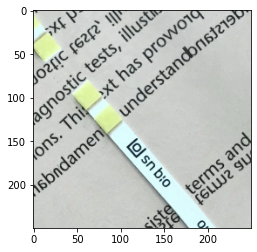

In [21]:
print(res[1][0][1] * 250)
plt.imshow(res[0][1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


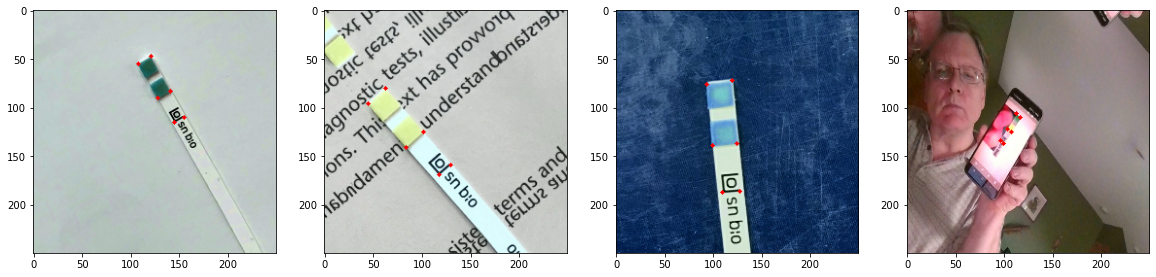

In [22]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]
    for pt in range(0,12,2):
        cv2.circle(sample_image, tuple(np.multiply((sample_coords[pt], sample_coords[pt+1]), [250,250]).astype(int)),   2, (255,0,0), -1)
    #cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

# 3. Build Model

### 3.1 Create Neural Network

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [44]:
#!conda install h5py
import h5py
print(h5py.version.info)

ImportError: DLL load failed while importing defs: The specified procedure could not be found.

In [37]:
model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    Reshape((12,))
])

ImportError: `load_weights` requires h5py package when loading weights from HDF5. Try installing h5py.

In [ ]:
model.summary()

### 3.2 Setup Losses and Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
model.compile(optimizer, loss)

### 3.3 Sense Check predictions

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

In [ ]:
scores = model.predict(X)

In [ ]:
scores

### 3.4 Train the Model

In [ ]:
# Train for 100 epochs
hist = model.fit(train, epochs=1, validation_data=val)

# 4. Review Performance

### 4.1 View Loss Plots

In [ ]:
hist.history

In [ ]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

### 4.2. Make Predictions on Test

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = model.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]
    
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250,250]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250,250]).astype(int)), 2, (0,255,0), -1)
    
    ax[idx].imshow(sample_image)

### 4.3. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('eyetrackerresnet.h5')

In [ ]:
model = load_model('eyetrackerresnet.h5')

In [ ]:
model.predict(test_sample[0])

# 5. Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    
    frame = frame[50:500,50:500,:] 
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))
    
    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0,:4]
    
    cv2.circle(frame, tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)), 2, (255,0,0), -1)
    cv2.circle(frame, tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 2, (0,255,0), -1)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()